In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib import image
import os

In [2]:
def mean_faces(X):
    mn,p = X.shape
    M = np.zeros((mn,1))
    for i in range(mn):
        for j in range(p):
            M[i] += X[i][j]
        M[i] /= p
    return M

def s_cov(X): 
    # Surrogate cov
    r,c = X.shape 
    cov = np.zeros((c,c))
    # Covariances        
    for z in range(c):
        for y in range(c):
                cov[z][y] = np.dot(X[:,y].T,X[:,z])/r                
    return cov 

def subtract_row(X,M):
# Subtracts M from X row wise    
    output = X
    n,c = X.shape
    for i in range(n):
        for j in range(c):
            output[i][j] = output[i][j] - M[i]
    return output

In [3]:
# loading 240 images for training & 160 for testing

train_image_list = []
test_image_list = []
for i in range(1,41):
    j = 1
    arr = os.listdir('s'+str(i)+'/')
    for img in arr:
        if(j <= 6):
            train_image_list.append((image.imread('s'+str(i)+'/'+img)).flatten())
        else:
            test_image_list.append((image.imread('s'+str(i)+'/'+img)).flatten())
        j+=1

## Training Phase

In [4]:
# 1. Apply PCA

# Generating the face dataset for training (60%)
Face_Db = np.array(train_image_list).T  
mn,p = Face_Db.shape

# Mean Calculation
M = mean_faces(Face_Db)

# Do mean Zero
delta = np.zeros((Face_Db.shape))
for i in range(mn):
    for j in range(p):
        delta[i][j] = Face_Db[i][j] - M[i]

# Covariance of delta (mean aligned faces)
cov = s_cov(delta)   

# eigenvalue and eigenvector decomposition (sorted)

eigenValues, eigenVectors = np.linalg.eig(cov)
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

# Finding the best direction (Generation of feature vectors)

k = 50
psi = eigenVectors[:,0:k]

# Generating Eigenfaces

Eigen_faces = np.dot(psi.T,delta.T)

# Generating Signature of Each Face
Signature = np.dot(Eigen_faces,delta)
#print(PF)

In [5]:
# 2. Divide the data into class

P=len(train_image_list)
n=6 #no. of images per person
number_of_classes=P//n
print(number_of_classes)

40


In [6]:
# 3. Calculate the means of each class 

mean_each_class = np.zeros((k,number_of_classes))
PF_classwise = []
for i in range(number_of_classes):
    mean_each_class[:,i] = mean_faces(Signature[:,6*i:6*i+6]).T
    PF_classwise.append(Signature[:,6*i:6*i+6])
    
PF_classwise = np.array(PF_classwise)
mean_PF = mean_faces(Signature)
#print(mean_PF)

In [7]:
mean_each_class.shape

(50, 40)

In [8]:
mean_PF.shape

(50, 1)

In [9]:
# 4. within class scatter matrix (SW)

SW = np.zeros((k,k))
for i in range(number_of_classes):
    var = subtract_row(PF_classwise[i],mean_each_class[:,i])
    SW += (np.dot(var,var.T))
    
SW.shape
#print(SW)

(50, 50)

In [10]:
# Between Class Scatter Matrix

SB = np.zeros((k,k))
for i in range(number_of_classes):
    M_i = np.reshape(mean_each_class[:,i],(1,mean_each_class[:,i].size)).T
    SB += (np.dot(subtract_row(M_i,mean_PF),M_i.T))

SB.shape
#print(SB)
    

(50, 50)

In [11]:
# 5. criterion function 

J=np.dot(np.linalg.inv(SW),SB)
print(J.shape)
#print(J)

(50, 50)


In [12]:
# 6. Eigen vector and Eigen values of the Criterion function

J_eigenValues, J_eigenVectors = np.linalg.eig(J)
idx = J_eigenValues.argsort()[::-1]   
J_eigenValues = J_eigenValues[idx]
J_ev = J_eigenVectors[:,idx]

J_ev.shape

(50, 50)

In [13]:
# 7. Best principal components

m = 50

In [14]:
# 8. Construct feature (W) vectors of using these k bests

W = J_ev[:,0:m]
W.shape

(50, 50)

In [15]:
# 9. Generate the fisher faces (FF)

FF = np.dot(W.T,Signature)

## Testing Phase

In [17]:
# 1. Read a test image

test_img=np.array(test_image_list).T
test_img.shape

(10304, 160)

In [18]:
# 2. Mean zero of the test 

Mean_img = np.zeros((test_img.shape))
for i in range(test_img.shape[1]):
    Mean_img[:,i] = np.subtract(test_img[:,i],np.mean(test_img[:,i]))
Mean_img.shape

(10304, 160)

In [19]:
# 3. Calculate the projected Eigen Face (PEF)

PEF = np.dot(Eigen_faces,Mean_img)
PEF.shape
#print(PEF)

(50, 160)

In [20]:
# 4. final projection (Projected Fisher Test Image)

Projected_Fisher_Test_Img = np.dot(W.T,PEF)
Projected_Fisher_Test_Img.shape
#print(Projected_Fisher_Test_Img)

(50, 160)

In [21]:
# 5. Euclidean distance between each column of the Fisher Faces to the Projected_Fisher_Test_img

def euclidean_dist(x1,x2):
    dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5
    return dist

def accuracy_fun(true_cl,pred_cl):
    count = 0
    for i in range(len(true_cl)):
        if(true_cl[i] == pred_cl[i]):
            count += 1
    accuracy_val = (count/len(true_cl))*100
    return accuracy_val

In [23]:
# column wise minimum distance calculation

import sys

true_Labels = np.arange(0,160)
true_Labels = (true_Labels//4)
accuracy_curve = []

for m in range(0,50):

    min_dist = sys.maxsize
    distances = [0] * test_img.shape[1]
    classes = [0] * test_img.shape[1]

    for i in range (Projected_Fisher_Test_Img.shape[1]):
        for j in range (FF.shape[1]):
            
            dist = euclidean_dist(Projected_Fisher_Test_Img[0:m,i],FF[0:m,j])
            
            if(dist < min_dist):
                min_dist = dist
                label = j

        distances[i] = min_dist
        classes[i] = (label//6)
        min_dist = sys.maxsize

    accuracy = accuracy_fun(true_Labels,classes)
    accuracy_curve.append(accuracy)
    

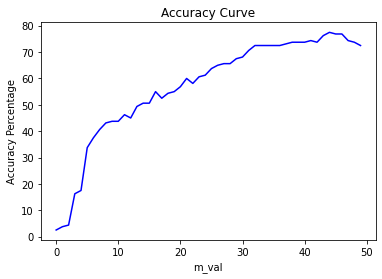

In [25]:
plt.plot(np.arange(0,50), accuracy_curve, color ="blue")  
plt.title("Accuracy Curve")  
plt.xlabel("m_val")  
plt.ylabel("Accuracy Percentage") 
plt.show()